In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
#loading the data ans making a data frame
df = pd.read_csv('Amish.csv')
df.head()

,frame_idx,t,theta,x,y,omega,alpha
0,1,0.033333,NaN,NaN,NaN,0.0,0.0
1,2,0.066667,NaN,NaN,NaN,NaN,NaN
2,3,0.100000,NaN,NaN,NaN,NaN,NaN
3,4,0.133333,NaN,NaN,NaN,NaN,NaN
4,5,0.166667,NaN,NaN,NaN,NaN,NaN


In [21]:
#keep the top 1800 values
df_new = df.head(1800)

In [22]:
#calculate sampling rate
total_frames = len(df_new)
duration = 60
sampling_rate = total_frames / duration
print(sampling_rate)

30.0


In [23]:
#segmenting 60s into 5s interval
frames_per_interval = int(round(5 * sampling_rate))
print(frames_per_interval)
n_segments = total_frames // frames_per_interval
print(n_segments)
segments = []
for i in range(n_segments):
  start = i * frames_per_interval
  end = start + frames_per_interval
  segments.append(df.iloc[start:end].copy().reset_index(drop=True))

150
12


In [24]:
#dividing the sengments as per role:
#first 2 in as minima and maximum
#remaining as the word utterance
[ref_min, ref_max] = segments[:2]
utterance = segments[2:]

In [25]:
#finding the reference angle (minima)
ref_min = ref_min.fillna(0.0)
reference_angle = ref_min[ref_min["theta"]>0]["theta"].mean()
reference_angle

np.float64(43.97681344186067)

In [26]:
reference_max_angle_avg = ref_max[ref_max["theta"]>reference_angle]["theta"].mean()
reference_max_angle = ref_max["theta"].max()
reference_max_angle_avg
reference_max_angle

55.92338555430738

Filling out nan values using Decision tree regression

In [27]:
from sklearn.impute import KNNImputer # Import KNNImputer

for i, segment_df in enumerate(utterance):
    print(f"Processing segment {i+1}/{len(utterance)}...")

    # Check if any NaN values exist in the current segment DataFrame
    if not segment_df.isnull().any().any():
        print(f"  No NaN values found in segment {i+1}. Skipping imputation.")
        continue

    print(f"  NaN values found in segment {i+1}. Applying KNN Imputer...")

    # Initialize KNNImputer with n_neighbors=5 as requested
    imputer = KNNImputer(n_neighbors=5)

    # Apply KNNImputer to the entire DataFrame.
    # KNNImputer returns a numpy array, so we convert it back to a DataFrame.
    imputed_data = imputer.fit_transform(segment_df.copy())

    # Create a new DataFrame from the imputed data, retaining original column names and index
    imputed_df = pd.DataFrame(imputed_data, columns=segment_df.columns, index=segment_df.index)

    # Update the corresponding segment in the 'utterance' list with the imputed DataFrame
    utterance[i] = imputed_df

print("NaN filling complete with KNN Imputer for all utterance segments.")

Processing segment 1/10...
  No NaN values found in segment 1. Skipping imputation.
Processing segment 2/10...
  No NaN values found in segment 2. Skipping imputation.
Processing segment 3/10...
  No NaN values found in segment 3. Skipping imputation.
Processing segment 4/10...
  No NaN values found in segment 4. Skipping imputation.
Processing segment 5/10...
  No NaN values found in segment 5. Skipping imputation.
Processing segment 6/10...
  No NaN values found in segment 6. Skipping imputation.
Processing segment 7/10...
  No NaN values found in segment 7. Skipping imputation.
Processing segment 8/10...
  No NaN values found in segment 8. Skipping imputation.
Processing segment 9/10...
  No NaN values found in segment 9. Skipping imputation.
Processing segment 10/10...
  No NaN values found in segment 10. Skipping imputation.
NaN filling complete with KNN Imputer for all utterance segments.


In [28]:
all_nan_filled = True
for i, segment_df in enumerate(utterance):
    if segment_df.isnull().any().any():
        print(f"Segment {i+1} still contains NaN values.")
        all_nan_filled = False
        break

if all_nan_filled:
    print("All NaN values in all utterance segments have been successfully filled.")
else:
    print("Some NaN values still exist in utterance segments.")


All NaN values in all utterance segments have been successfully filled.


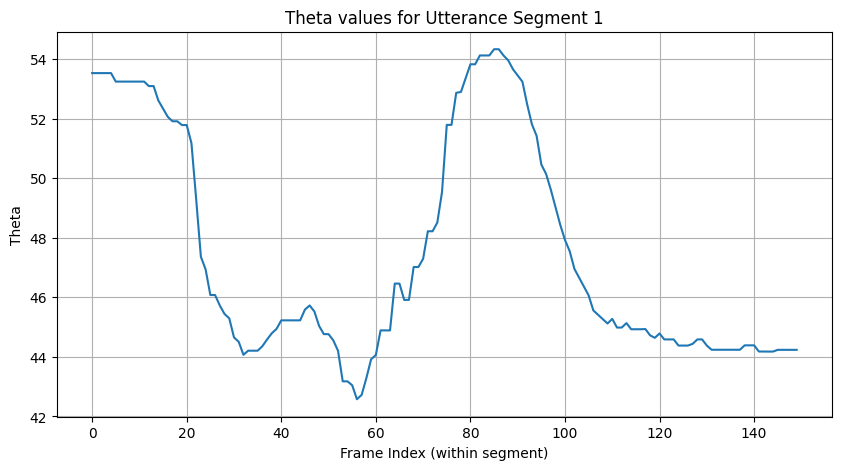

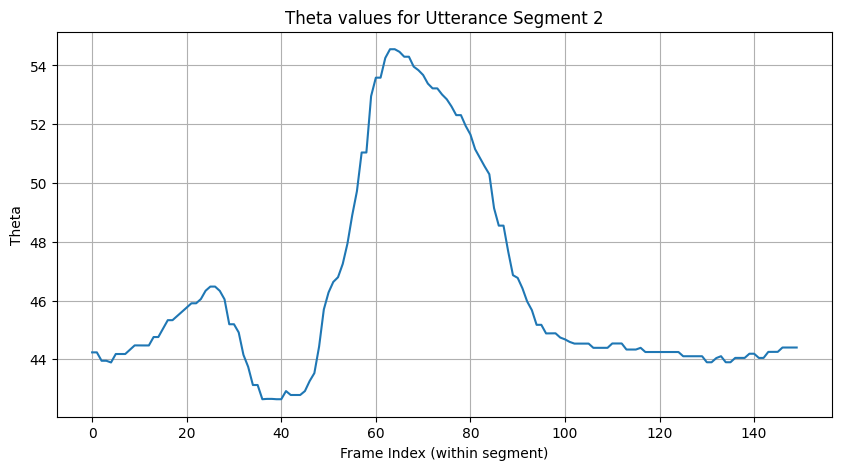

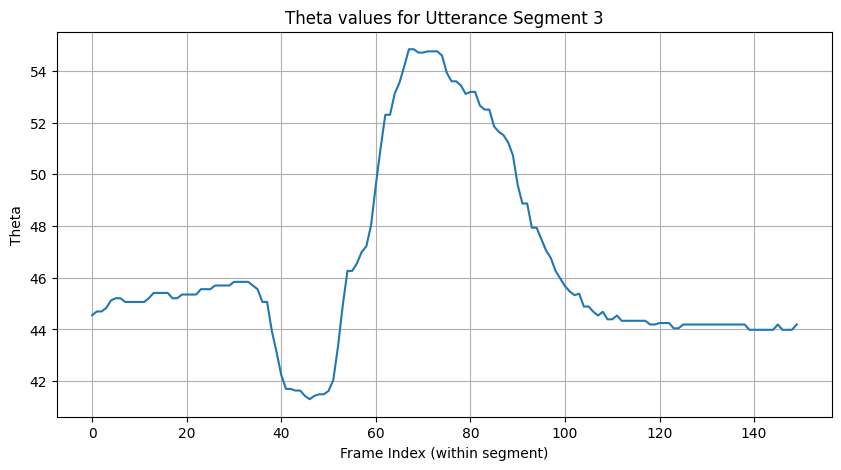

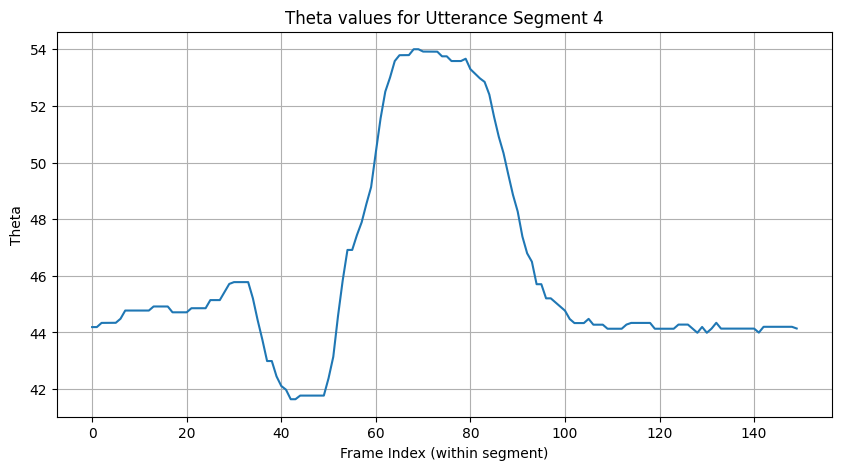

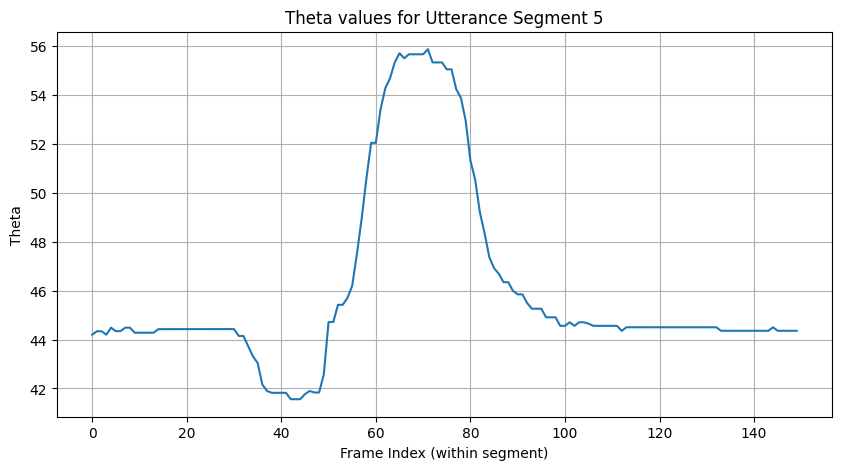

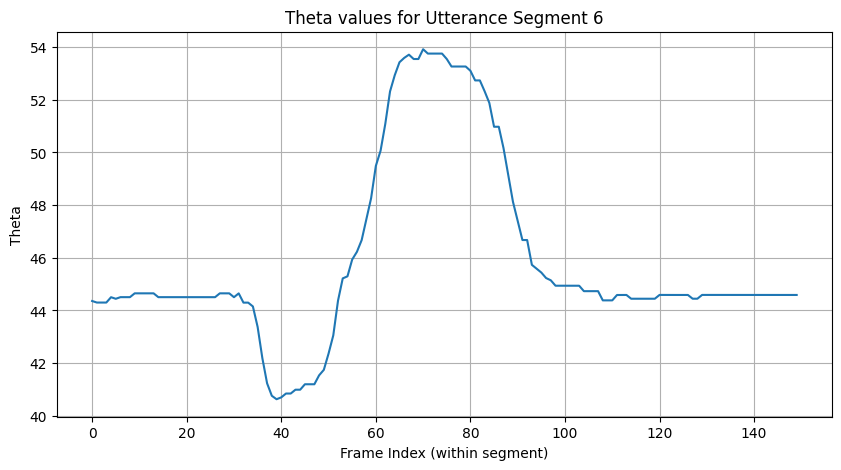

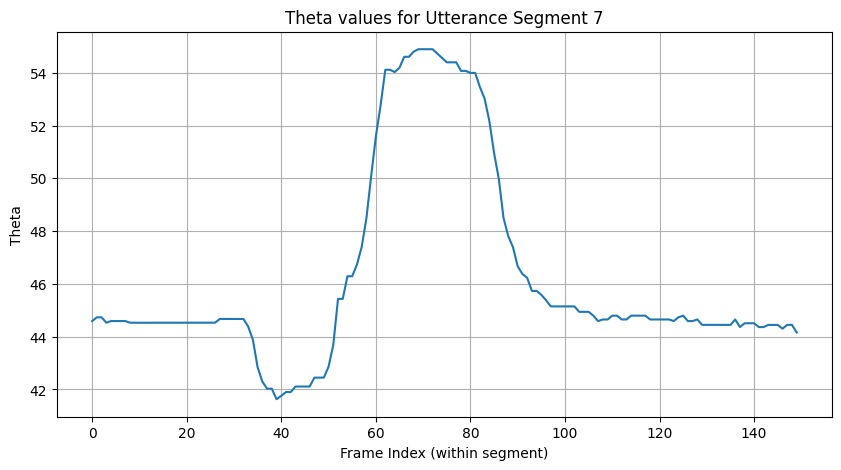

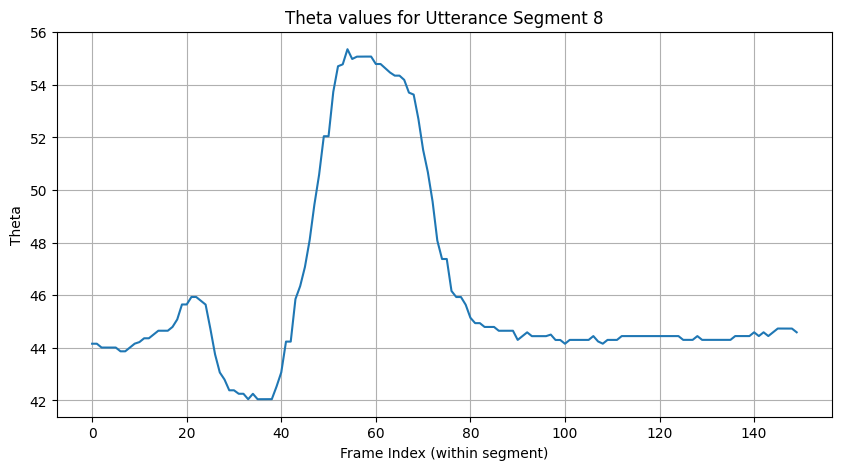

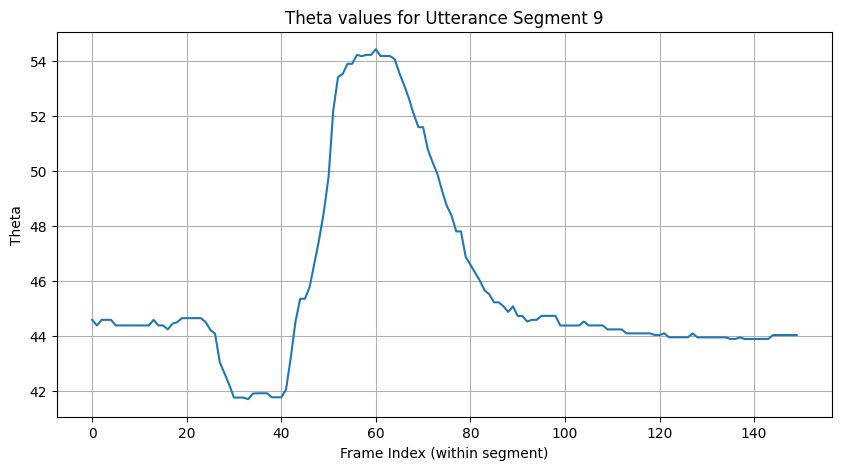

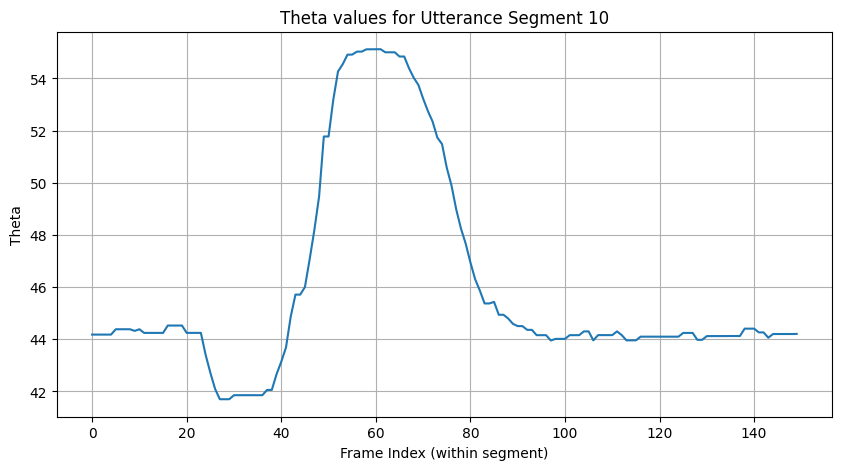

In [29]:
import matplotlib.pyplot as plt

for i, segment_df in enumerate(utterance):
    plt.figure(figsize=(10, 5))
    plt.plot(segment_df.index, segment_df['theta'])
    plt.title(f'Theta values for Utterance Segment {i+1}')
    plt.xlabel('Frame Index (within segment)')
    plt.ylabel('Theta')
    plt.grid(True)
    plt.show()


In [30]:
import numpy as np

for i, segment_df in enumerate(utterance):
    # Identify spikes: values below reference_angle or above reference_max_angle
    spikes_mask = (segment_df['theta'] < reference_angle) | (segment_df['theta'] > reference_max_angle)

    # Replace spikes with NaN
    utterance[i].loc[spikes_mask, 'theta'] = np.nan

    # Fill NaN values using linear interpolation
    # limit_direction='both' ensures NaNs at the beginning/end are filled if possible
    # limit_area='inside' interpolates only within existing non-NaN values
    utterance[i]['theta'] = utterance[i]['theta'].interpolate(method='linear', limit_direction='both', limit_area='inside')

print("Spikes removed and NaNs filled with linear interpolation for all utterance segments.")

Spikes removed and NaNs filled with linear interpolation for all utterance segments.


In [31]:
for i, segment_df in enumerate(utterance):
    # Normalize 'theta' values to a 0-1 scale
    utterance[i]['theta'] = (segment_df['theta'] - segment_df['theta'].mean()) / (segment_df['theta'].std())

print("Theta values normalized to 0-1 scale for all utterance segments.")

Theta values normalized to 0-1 scale for all utterance segments.


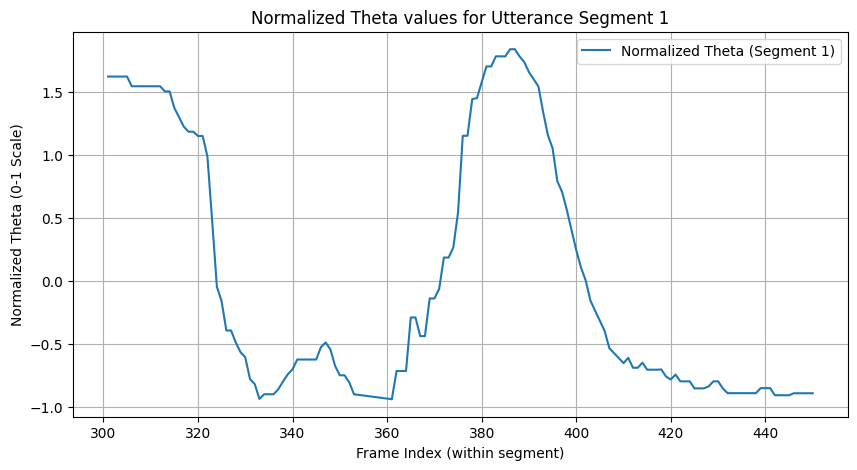

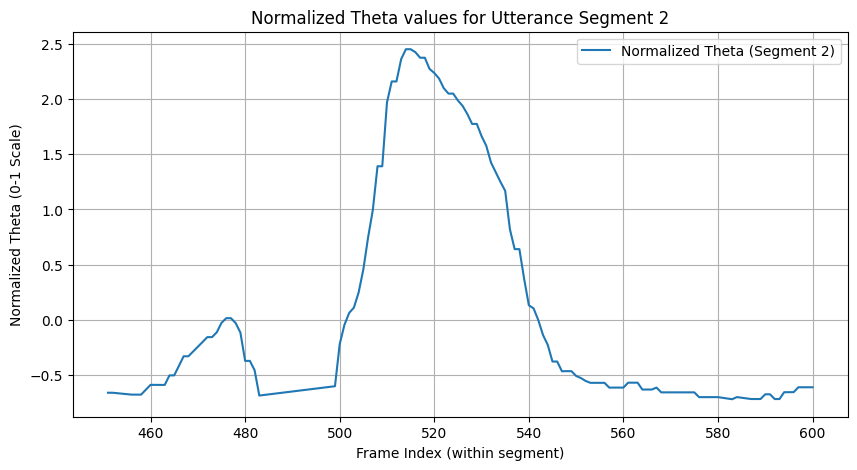

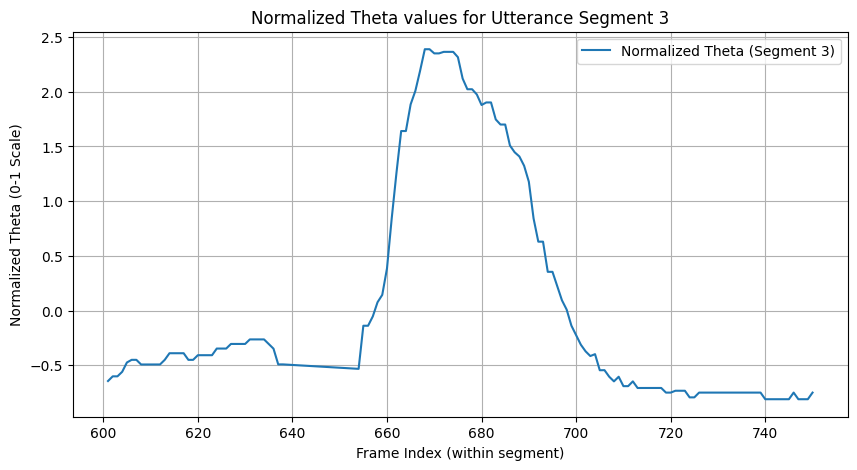

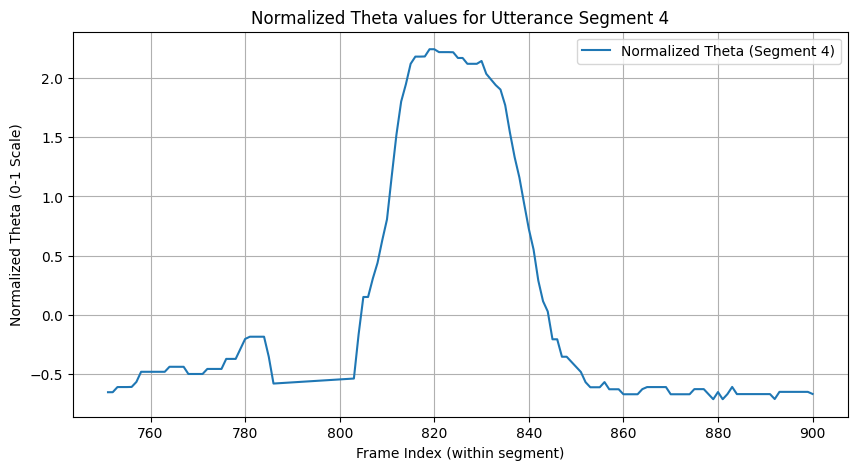

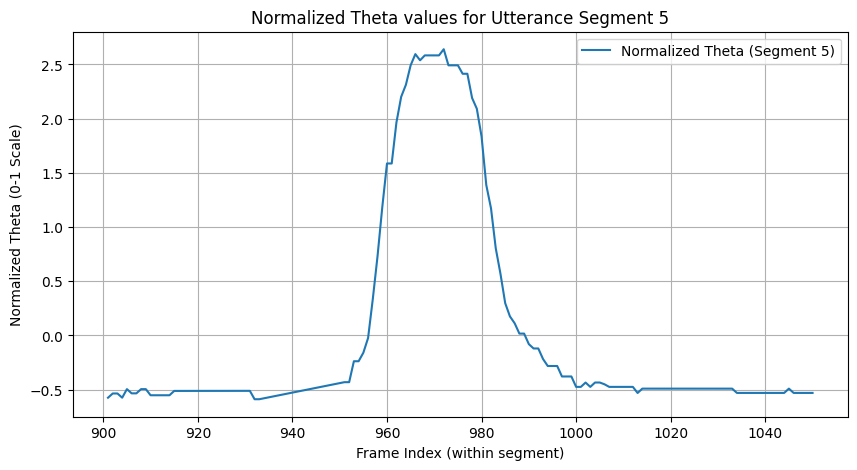

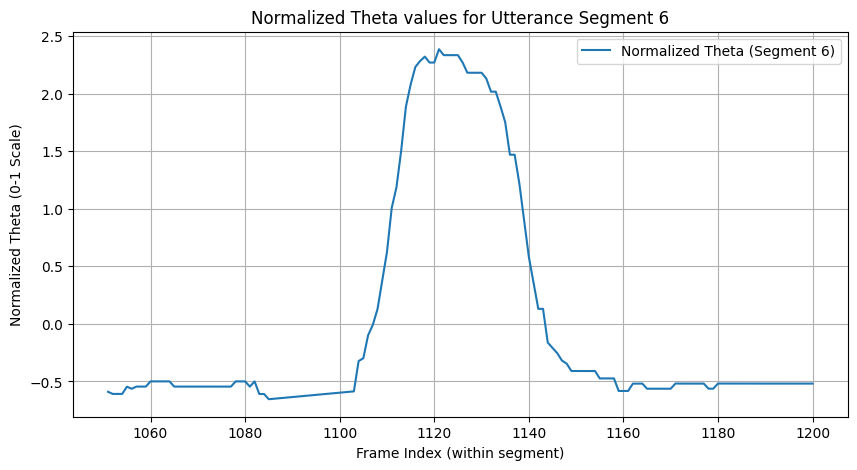

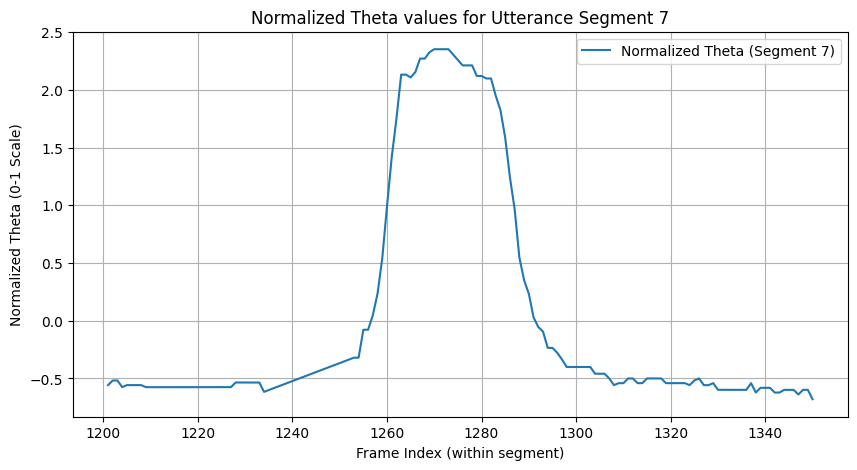

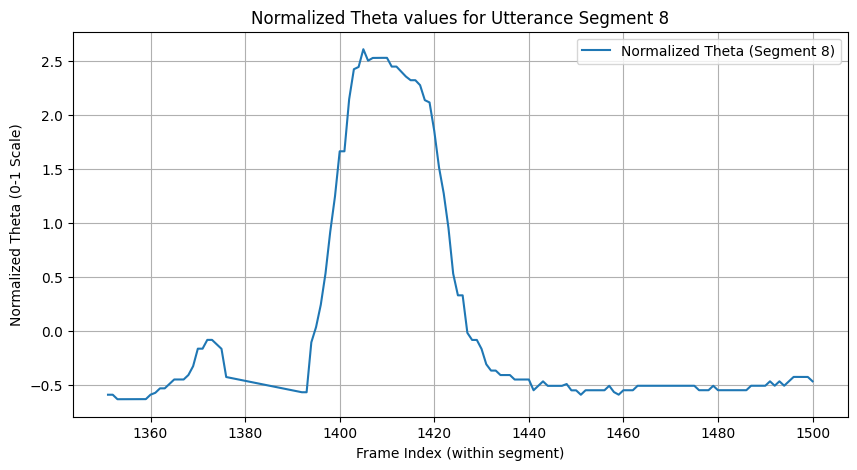

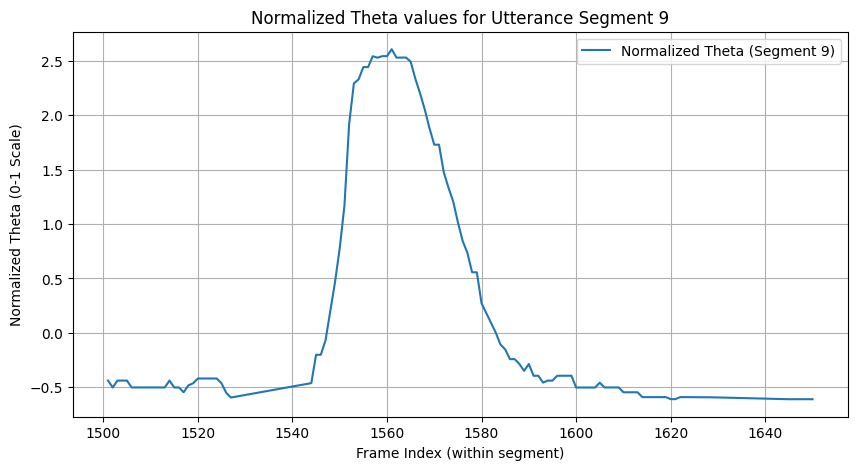

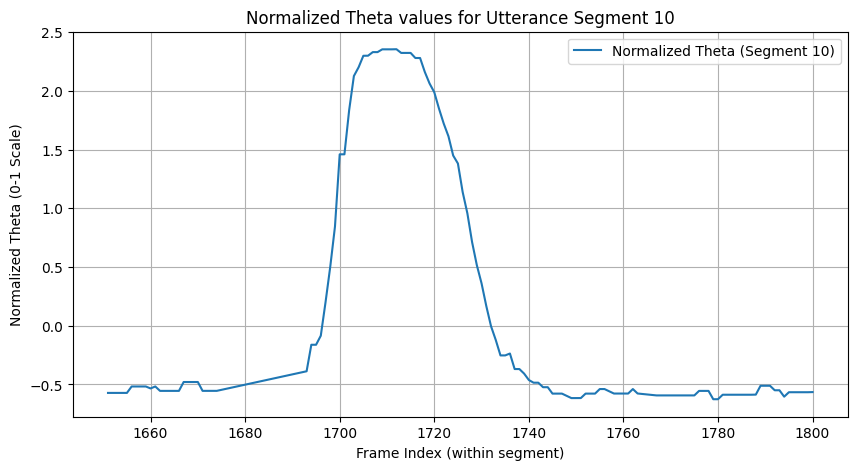

Visualizations of normalized theta values for all utterance segments completed.


In [35]:
import matplotlib.pyplot as plt

for i, segment_df in enumerate(utterance):
    plt.figure(figsize=(10, 5))
    plt.plot(segment_df["frame_idx"], segment_df['theta'], label=f'Normalized Theta (Segment {i+1})')
    plt.title(f'Normalized Theta values for Utterance Segment {i+1}')
    plt.xlabel('Frame Index (within segment)')
    plt.ylabel('Normalized Theta (0-1 Scale)')
    plt.grid(True)
    plt.legend()

plt.show()

print("Visualizations of normalized theta values for all utterance segments completed.")

In [33]:
#problem is that for subjects that have min and max angle ~ 1-2 degrees than, normalization is tough.

In [44]:
utterance
type(utterance)

list

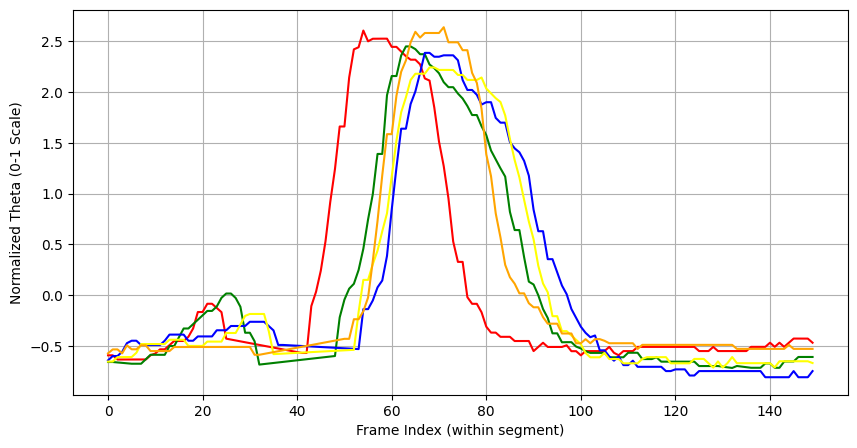

In [62]:
#visual sanity
#Plot 10 utterances of the same word overlaid.
#Plot 10 utterances of different words overlaid.

list_num = [i for i in range(0, 150)]

plt.figure(figsize=(10, 5))
plt.plot(list_num, utterance[7]['theta'], color="red")
plt.plot(list_num, utterance[1]['theta'], color="green")
plt.plot(list_num, utterance[2]['theta'], color="blue")
plt.plot(list_num, utterance[3]['theta'], color="yellow")
plt.plot(list_num, utterance[4]['theta'], color="orange")
plt.xlabel('Frame Index (within segment)')
plt.ylabel('Normalized Theta (0-1 Scale)')
plt.grid(True)
plt.show()


In [ ]:
# plt.figure(figsize=(10, 5))
# plt.plot(list_num, utterance[7]['theta'], color="red")
# plt.plot(list_num, utterance[1]['theta'], color="green")
# plt.plot(list_num, utterance[2]['theta'], color="blue")
# plt.plot(list_num, utterance[3]['theta'], color="yellow")
# plt.plot(list_num, utterance[4]['theta'], color="orange")
# plt.xlabel('Frame Index (within segment)')
# plt.ylabel('Normalized Theta (0-1 Scale)')
# plt.grid(True)
# plt.show()

per utterance :
<br>
amplitude and shape
* mean - average jaw angle
* std - variability of jaw angle
* range - total motion span
* rms - motion energy level
* median - robust central level
* kurtosis - asymmetry of motion distribution
* skewness - peakedness/heaviness of motion distribution


In [75]:
utterance_range = []
utterance_rms = []
utterance_median = []
utterance_kurtosis = []
utterance_skewness = []

for i in range(10):
    x = utterance[i]["theta"].values
    n = len(x)
    mu = np.mean(x)
    sigma = np.std(x, ddof=1)
    z = (x - mu) / sigma

    utterance_range.append(np.max(x) - np.min(x))
    utterance_rms.append(np.sqrt(np.mean(x**2)))
    utterance_median.append(np.median(x))
    utterance_kurtosis.append(np.mean(z**4) - 3)   # excess kurtosis
    utterance_skewness.append(np.mean(z**3))


In [76]:
df_utterance = pd.DataFrame(list(zip(utterance_range, utterance_rms, utterance_median, utterance_kurtosis, utterance_skewness)))
df_utterance.columns = ["range", "rms", "median", "kurtosis", "skewness"]
df_utterance.head()

,range,rms,median,kurtosis,skewness
0,2.770968,0.996661,-0.566918,-1.208267,0.717822
1,3.169877,0.996661,-0.569285,0.338833,1.376073
2,3.197571,0.996661,-0.450173,0.247109,1.342902
3,2.958895,0.996661,-0.501248,0.264409,1.395536
4,3.229214,0.996661,-0.490747,1.564667,1.792755


Dynamics
<br>
* Mean absolute slope — average jaw movement spread
* Zero-crossing rate of derivative — rate of motion direction reversals
* Slope sign changes — complexity/jitter in articulation dynamics

Structure
* Number of peaks — number of jaw opening events
* Mean Peak amplitude
* mean inter-peak distance

Trajectory
* Waveform length
* Average amplitude change
* Energy - the total amount of motion activity present in the jaw trajectory over the utterance

In [77]:
from scipy.signal import find_peaks

utterance_energy = []
utterance_mean_absolute = []
utterance_zcr = []
utterance_ssc = []
waveform_length = []
average_amplitude_change = []
num_peaks = []
mean_peak_amplitude = []
mean_interpeak_distance = []

n =150
for i in range(0 ,10):
  x = utterance[i]["theta"].values
  d = np.diff(x)
  utterance_energy.append(np.sum(x**2)/n)
  utterance_mean_absolute.append(np.mean(np.abs(np.diff(x))))
  utterance_zcr.append(np.sum(np.sign(d[1:]) != np.sign(d[:-1]))/ len(d))
  utterance_ssc.append(np.sum((d[1:] > 0) & (d[:-1] < 0) | (d[1:] < 0) & (d[:-1] > 0)))
  waveform_length.append(np.sum(np.abs(d)))
  average_amplitude_change.append(np.mean(np.abs(d)))

In [83]:
df_utterance_frequency = pd.DataFrame(list(zip(utterance_energy, utterance_mean_absolute, utterance_zcr, utterance_ssc, waveform_length, average_amplitude_change)))
df_utterance_frequency.columns = ["energy", "mas", "zcr", "ssc", "waveform","del_amp"]

In [84]:
df_utterance_frequency.head()

,energy,mas,zcr,ssc,waveform,del_amp
0,0.993333,0.065156,0.409396,9,9.708194,0.065156
1,0.993333,0.054185,0.402685,6,8.073597,0.054185
2,0.993333,0.050726,0.463087,11,7.558105,0.050726
3,0.993333,0.050481,0.395973,9,7.521629,0.050481
4,0.993333,0.048619,0.395973,10,7.244183,0.048619
